In [1]:
import sqlite3
import pandas as pd

# Ruta a tu archivo de base de datos
db_path = "/Users/edgarpreciado/Downloads/chinook.db"

# Conexión
conn = sqlite3.connect(db_path)

# Crear un cursor (opcional, solo si quieres ejecutar comandos uno por uno)
cursor = conn.cursor()

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
print(os.path.exists(db_path))

True


## 🔹 Consultas básicas (calentamiento)

### ¿Cuántos clientes hay en cada país?
Permite identificar en qué países se concentran más clientes y dónde hay oportunidades de crecimiento. Si un país tiene muchos clientes, conviene dirigir más campañas publicitarias o promociones allí. Por el contrario, si un país tiene pocos clientes, se pueden diseñar estrategias para aumentar la presencia.

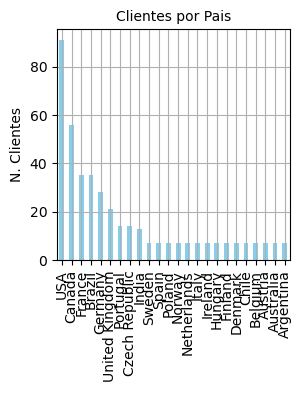

In [6]:
query = """
select i.BillingCountry as Country, COUNT(i.BillingCountry) as No_clientes from invoices i
group  by country order by No_clientes DESC ; 
"""

df = pd.read_sql_query(query, conn)
df.plot(
    kind="bar",        # tipo de gráfico
    x="Country",          # eje X
    y="No_clientes",        # eje Y
    legend=False,      # sin leyenda
    color="skyblue",     # color opcional
    label = 'Ventas', 
    figsize=(3,3), 
    xlabel = " ", 
    ylabel = "N. Clientes")

plt.title("Clientes por Pais", fontsize = 10)
plt.grid()
plt.show()

### Lista los 10 artistas con más álbumes registrados.
Nos dice quiénes han aportado más contenido al catálogo. Esto ayuda a entender qué artistas son más relevantes en términos de volumen de oferta.
Más álbumes no siempre significa más ventas. Este ranking se puede cruzar con los ingresos para responder:
¿Los artistas más productivos también son los más vendidos?
¿Qué tan rentable es cada artista en relación con su producción? EN la grafica Artistas con más ventas observamos que el artista más productivo (Iron Maiden) es el más rentable. 

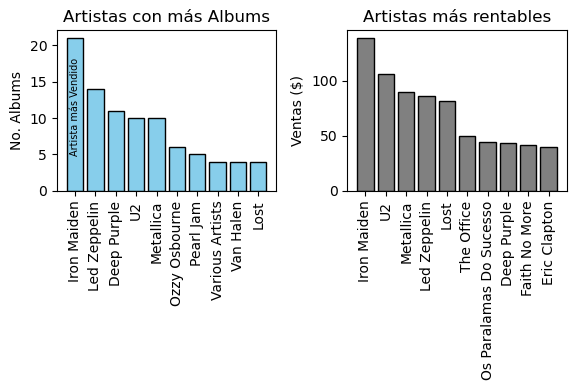

In [54]:
query = """
SELECT a2.Name as Artista, Count(a2.Name) as No_Albums from albums a
inner join artists a2 on a.ArtistId  = a2.ArtistId
group by Artista order by No_Albums DESC
limit 10; 

"""
dfA = pd.read_sql_query(query, conn)

query = """
select  ar.Name as Artista, sum(ii.UnitPrice) as Venta from invoices i 
inner join invoice_items ii on i.InvoiceId  = ii.InvoiceId 
inner join tracks t on t.TrackId = ii.TrackId 
inner join albums a on a.AlbumId  = t.AlbumId 
inner join artists ar  on ar.ArtistId = a.ArtistId 
group by Artista order by Venta DESC limit 10; 

"""
dfV = pd.read_sql_query(query, conn)

fig, axs = plt.subplots(1, 2, figsize=(6, 4))

# Primer subplot
axs[0].bar(dfA['Artista'], dfA['No_Albums'], color="skyblue", edgecolor="black")
axs[0].set_title("Artistas con más Albums")
axs[0].set_ylabel("No. Albums")
axs[0].tick_params(axis="x", rotation=90)
axs[0].text(0, 5, 'Artista más Vendido', ha="center", fontsize=7, rotation=90)
# Segundo subplot
axs[1].bar(dfV['Artista'], dfV['Venta'], color="grey", edgecolor="black")
axs[1].set_title("Artistas más rentables")
axs[1].set_ylabel("Ventas ($)")
axs[1].tick_params(axis="x", rotation=90)

# Ajustar espacios entre gráficos
plt.tight_layout()
plt.savefig("Generos_USAB.png")


plt.show()

### ¿Qué géneros tienen más canciones en la base de datos?
Nos da una visión de qué géneros dominan la base de datos. Esto es clave para entender hacia dónde está orientada la oferta musical. Permite evaluar si hay un equilibrio entre géneros o si la base está concentrada en unos pocos. Esto ayuda a detectar oportunidades para diversificar.En la grafica abajo "Ventas por Genero" obsrvamos el porcentaje de ventas por genero. El rock es el genero más rentable. 

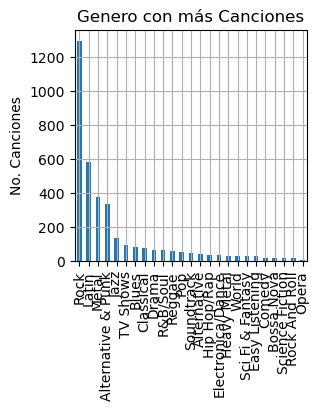

In [36]:
query = """
select g.Name as Genero,  count(t.GenreId) as N_Canciones from tracks t
inner join genres g  on t.GenreId = g.GenreId 
group by t.GenreId order by N_Canciones DESC ; 

"""
df = pd.read_sql_query(query, conn)
df.set_index("Genero")['N_Canciones'].plot(
    figsize=(3,3),
    kind="bar",   
    legend=False, 
    #autopct="%1.1f%%", 
    ylabel="No. Canciones", 
    xlabel="")

plt.title("Genero con más Canciones")
#plt.text('Drama', 1200, 'MAs', ha="center", fontsize=9, color="blue")
plt.grid()
plt.show()

### ¿Qué empleados trabajan en cada ciudad y quién es su jefe?

In [167]:
query = """
select concat(e.FirstName, e.LastName) as Empleado, e.City, concat(e2.FirstName, e2.LastName) as Manager from employees e
inner join employees e2 on e.ReportsTo = e2.EmployeeId limit 8;
"""
df = pd.read_sql_query(query, conn)
df.head(8)


,Empleado,City,Manager
0,NancyEdwards,Calgary,AndrewAdams
1,JanePeacock,Calgary,NancyEdwards
2,MargaretPark,Calgary,NancyEdwards
3,SteveJohnson,Calgary,NancyEdwards
4,MichaelMitchell,Calgary,AndrewAdams
5,RobertKing,Lethbridge,MichaelMitchell
6,LauraCallahan,Lethbridge,MichaelMitchell


## Consultas intermedias (JOINs dobles o triples)

### ¿Cuál es la canción qué más ha vendido? 
The Trooper 4.95 en ventas.  Saber qué pista es la más vendida permite conocer cuál es el “hit” del catálogo, el que atrae más clientes y genera más ingresos. Se puede cruzar este dato con el número de canciones por género o artista para preguntar:
¿El género más grande también tiene la canción más vendida?
¿Un artista con pocos álbumes logró colocar el mayor éxito?

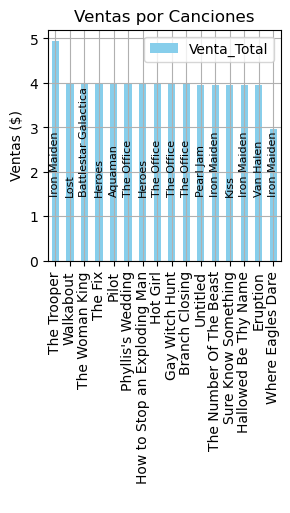

In [61]:
### ¿Cuál es la canción qué más ha vendido (según el precio unitario en `InvoiceLine`)? 
query = """
select t.Name  as Nombre, ar.Name as Artist, Sum(ii.UnitPrice) as Venta_Total from invoices i 
inner join invoice_items ii on ii.InvoiceId  = i.InvoiceId
inner join tracks t on t.TrackId  = ii.TrackId 
inner join albums a on a.AlbumId  = t.AlbumId 
inner join artists ar  on ar.ArtistId = a.ArtistId 
GROUP by Nombre order by Venta_Total DESC limit 16; 

"""

df = pd.read_sql_query(query, conn)
df.plot(
    kind="bar",        # tipo de gráfico
    x="Nombre",          # eje X
    y="Venta_Total",        # eje Y
    legend=True,      # sin leyenda
    color="skyblue", 
    figsize=(3,3), 
    xlabel = " "# color opcional
)
for i, j in enumerate(df['Artist']):  
    plt.text(i, 1.5, j, ha="center", fontsize=8, rotation=90)
    
plt.title("Ventas por Canciones")
plt.ylabel("Ventas ($)")
plt.grid()
plt.show()

### ¿Qué artista tiene más canciones en la base de datos y cuántas?  
El artista con más canciones es el más vendido.  

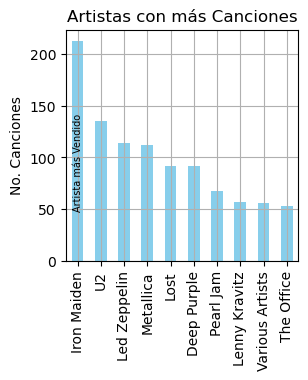

In [65]:
query = """
select ar.Name as Artist, COUNT(t.AlbumId ) as Cuenta from tracks t  
inner join albums a on a.AlbumId = t.AlbumId 
inner join artists ar on ar.ArtistId = a.ArtistId
GROUP by Artist order by Cuenta DESC limit 10; 

"""

df = pd.read_sql_query(query, conn)

df.set_index("Artist")['Cuenta'].plot(
    figsize=(3,3),
    kind="bar",   
    legend=False, 
    #autopct="%1.1f%%", 
    ylabel="No. Canciones", 
    xlabel="",
    color = 'skyblue')
plt.text(0, 50, 'Artista más Vendido', ha="center", fontsize=7, rotation=90)
plt.title("Artistas con más Canciones")
plt.grid()
plt.show()

### Lista los 5 clientes principales de cada país. 
Permite saber quiénes son los clientes que más contribuyen a los ingresos por país, lo cual es esencial para priorizar esfuerzos comerciales y de fidelización. Se pueden diseñar campañas personalizadas para los clientes que más compran, por ejemplo: promociones exclusivas, ofertas especiales o programas de lealtad. Las empresas pueden asignar más atención a los países y clientes que generan más ingresos, optimizando tiempo y presupuesto.

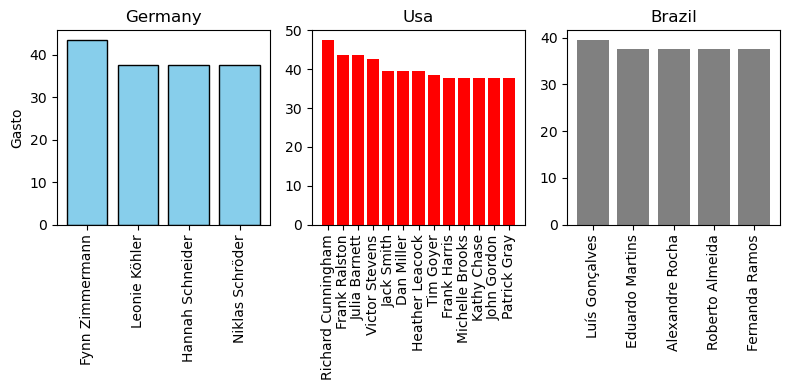

In [66]:
query = """
select concat(c.FirstName, ' ', c.LastName) as Name, i.BillingCountry as Country, Sum(i.Total) as Gasto from invoices i 
inner join customers c on c.CustomerId = i.CustomerId 
where i.BillingCountry in ('USA' , 'Canada', 'France', 'Brazil', 'Germany')
group by i.CustomerId order by i.BillingCountry DESC, gasto DESC; 

"""

df = pd.read_sql_query(query, conn)
df_usa = df[df["Country"] == "USA"]
df_BRAZIL = df[df["Country"] == "Brazil"]
df_Germany = df[df["Country"] == "Germany"]


# Crear figura con 2 subplots (2 filas, 1 columna)
fig, axs = plt.subplots(1, 3, figsize=(8, 4))

# Primer subplot
axs[0].bar(df_Germany['Name'], df_Germany['Gasto'], color="skyblue", edgecolor="black")
axs[0].set_title("Germany")
axs[0].set_ylabel("Gasto")
axs[0].tick_params(axis="x", rotation=90)
# Segundo subplot
axs[1].bar(df_usa['Name'], df_usa['Gasto'], color="red")
axs[1].set_title("Usa")
axs[1].tick_params(axis="x", rotation=90)
# Tercer subplot
axs[2].bar(df_BRAZIL['Name'], df_BRAZIL['Gasto'], color="grey")
axs[2].set_title("Brazil")
axs[2].tick_params(axis="x", rotation=90)

# Ajustar espacios entre gráficos
plt.tight_layout()
plt.show()


### ¿Qué empleados han generado más ingresos por ventas (sumando sus facturas asociadas)?
Jane Peacock ha generado 833.04 en ventas. Nos permite reconocer a los vendedores que aportan más ingresos, lo que es útil para recompensar desempeño, motivar al equipo y compartir buenas prácticas. Si ciertos empleados logran mayores ventas con determinados clientes o regiones, se puede replicar esa estrategia en otras áreas o asignar clientes estratégicamente. Comparando ingresos generados por cada empleado se puede medir productividad relativa y detectar áreas de mejora o necesidad de capacitación. Permite basar programas de bonificación, premios o comisiones en datos reales de ventas, incentivando al personal a maximizar ingresos.

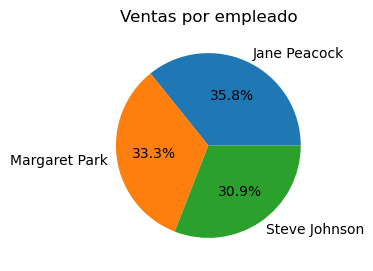

In [67]:
query = """
select Concat(e.FirstName,' ', e.LastName)as Name,  sum(i.Total) as Ventas_Total from invoices i 
inner join customers c on i.CustomerId  = c.CustomerId 
inner join employees e  on e.EmployeeId = c.SupportRepId
group by Name; 

"""
df = pd.read_sql_query(query, conn)
df.set_index("Name")['Ventas_Total'].plot(
    figsize=(3,3),
    kind="pie",   
    legend=False, 
    autopct="%1.1f%%", 
    ylabel="")
plt.title("Ventas por empleado")
plt.show()

## Consultas avanzadas (CTEs, subconsultas, agrupamientos)

### ¿Qué país tiene el mayor gasto promedio por cliente?
En la grafica "Comparación de % y AVG por País" podremos comparar este dato con el porcentaje de las ventas totales que representa cada pais. 


In [68]:
query = """
select i.BillingCountry as Country , AVG(i.Total ) as Promedio from invoices i 
group by Country order by Promedio DESC limit 10; 

"""
df = pd.read_sql_query(query, conn)
df.head()

,Country,Promedio
0,Chile,6.660000
1,Ireland,6.517143
2,Hungary,6.517143
3,Czech Republic,6.445714
4,Austria,6.088571


### Encuentra el mes con mayores ventas en toda la historia de ventas en la Base de Datos. Ventas por Año. 

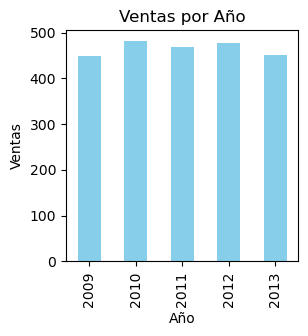

In [211]:
query = """
SELECT 
    strftime('%Y', i.InvoiceDate) AS AnoMes,
    SUM(i.Total) AS Ventas
FROM invoices i
GROUP BY AnoMes
ORDER BY AnoMes Asc;  
"""

df = pd.read_sql_query(query, conn)
df.head()

ventas = df['Ventas']
AnoMes = df['AnoMes'].astype(int)

df.plot(
    kind="bar",        # tipo de gráfico
    x="AnoMes",          # eje X
    y="Ventas",        # eje Y
    legend=False,      # sin leyenda
    color="skyblue", 
     figsize=(3,3)# color opcional
)

plt.title("Ventas por Año")
plt.xlabel("Año")
plt.ylabel("Ventas")
plt.show()

In [212]:
import pmdarima as pm

# Serie como array
y = np.array(ventas)

# Ajuste automático ARIMA
modelo = pm.auto_arima(
    y,
    seasonal=False,     # Son datos anuales (no hay estacionalidad mensual)
    stepwise=True,      # Búsqueda eficiente
    suppress_warnings=True,
    trace=False          # Muestra el proceso de selección
)

print(modelo.summary())

/Users/edgarpreciado/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/edgarpreciado/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/edgarpreciado/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/edgarpreciado/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/edgarpreciado/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    5
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -18.985
Date:                Mon, 15 Sep 2025   AIC                             43.970
Time:                        22:09:32   BIC                             42.798
Sample:                             0   HQIC                            40.825
                                  - 5                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    838.6070    441.407      1.900      0.057     -26.535    1703.749
ar.L1         -0.7877      0.928     -0.849      0.396      -2.606       1.031
sigma2        95.9028    227.415      0.422      0.6

/Users/edgarpreciado/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


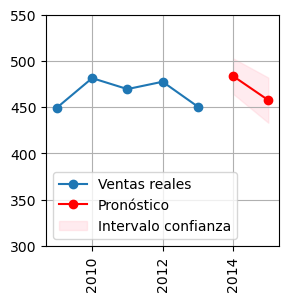

In [214]:
n_periods = 2
pred, conf_int = modelo.predict(n_periods=n_periods, return_conf_int=True)
# Crear rango de fechas mensual
anos_futuros = [2014, 2015]

# Graficar
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
plt.plot(AnoMes, y, marker="o", label="Ventas reales")
plt.ylim(300,550)
plt.plot(anos_futuros, pred, marker="o", label="Pronóstico", color="red")
plt.fill_between(anos_futuros, conf_int[:,0], conf_int[:,1], 
                 color="pink", alpha=0.3, label="Intervalo confianza")
plt.tick_params(axis="x", rotation=90)
plt.legend()
plt.grid(True)
plt.savefig("Preduccion_Ventas.png")
plt.show()

### ¿Qué género prefieren los clientes de USA frente a los de Brasil?
Generaremos dos Histogramas y compararemos; Cada país puede tener gustos musicales distintos. Conocer los géneros preferidos permite al negocio adaptar su catálogo, promociones y recomendaciones según la cultura y tendencia local. Si sabemos que los clientes de USA prefieren Rock y los de Brasil Samba, podemos diseñar campañas personalizadas, playlists exclusivas o paquetes promocionales que apelen a cada audiencia.

In [69]:
query1 = """
SELECT  g.Name, count(g.Name) as Count  FROM invoices i
inner join invoice_items ii on i.InvoiceId = ii.InvoiceId 
inner join tracks t on ii.TrackId = t.TrackId 
inner join genres g on g.GenreId  = t.GenreId 
where   i.BillingCountry in (select i2.BillingCountry  from invoices i2 
where i2.BillingCountry in ('USA'))
group by g.Name order by Count Desc 
limit 10; 
"""

query2 = """
SELECT  g.Name, count(g.Name) as Count  FROM invoices i
inner join invoice_items ii on i.InvoiceId = ii.InvoiceId 
inner join tracks t on ii.TrackId = t.TrackId 
inner join genres g on g.GenreId  = t.GenreId 
where   i.BillingCountry in (select i2.BillingCountry  from invoices i2 
where i2.BillingCountry in ('Brazil'))
group by g.Name order by Count Desc
limit 10; 
"""

df_usa = pd.read_sql_query(query1, conn)
df_Brazil = pd.read_sql_query(query2, conn)

Count_USA = df_usa['Count']
Name_USA = df_usa['Name']

Count_B = df_Brazil['Count']
Name_B = df_Brazil['Name']


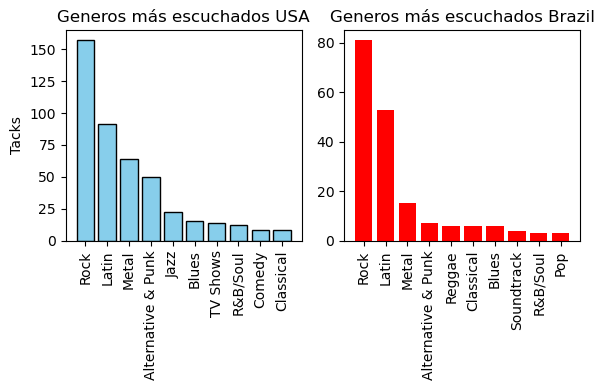

In [70]:
# Crear figura con 2 subplots (2 filas, 1 columna)
fig, axs = plt.subplots(1, 2, figsize=(6, 4))

# Primer subplot
axs[0].bar(Name_USA, Count_USA, color="skyblue", edgecolor="black")
axs[0].set_title("Generos más escuchados USA")
axs[0].set_ylabel("Tacks")
axs[0].tick_params(axis="x", rotation=90)
# Segundo subplot
axs[1].bar(Name_B, Count_B, color="red")
axs[1].set_title("Generos más escuchados Brazil")
axs[1].tick_params(axis="x", rotation=90)

# Ajustar espacios entre gráficos
plt.tight_layout()
plt.savefig("Generos_USAB.png")


plt.show()

### ¿Cuál es el promedio de duración (en minutos) de las canciones por género?
Permite conocer cómo se distribuyen las canciones según su duración dentro de cada género. Por ejemplo, algunos géneros suelen tener canciones más largas (como el jazz) y otros más cortas (como el pop). La duración promedio, combinada con datos de ventas o streaming, puede indicar preferencias de los usuarios por canciones más cortas o largas.

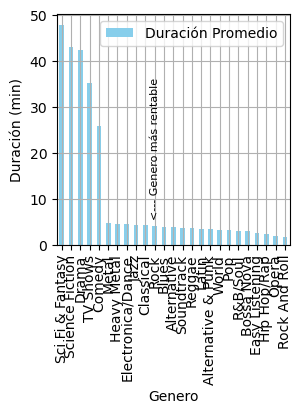

In [75]:
query = """
select g.Name as Genero , Round(Avg(t.Milliseconds/60000),1)  as p_minutes from tracks t
inner join genres g on g.GenreId = t.GenreId 
GROUP  by Genero order by p_minutes Desc;  
"""

df = pd.read_sql_query(query, conn)
df.head()

df.plot(
    kind="bar",        # tipo de gráfico
    x="Genero",          # eje X
    y="p_minutes",        # eje Y
    legend=True,      # sin leyenda
    color="skyblue",     # color opcional
    label = 'Duración Promedio', 
     figsize=(3,3)
)
plt.text(10, 6, '<--- Genero más rentable', ha="center", fontsize=8, rotation=90)
plt.ylabel("Duración (min)")
plt.grid()
plt.show()

### ¿Cuál es el ingreso total generado por cada artista?
No basta con saber cuántos álbumes o canciones tiene un artista; lo realmente relevante para el negocio es cuánto dinero genera. Esto ayuda a identificar los artistas más valiosos financieramente. Se puede decidir qué artistas o géneros destacar en la plataforma, playlists o bundles, basado en su impacto económico real. Al unir los ingresos por artista con el género o país de los clientes, se pueden obtener insights sobre preferencias regionales o tendencias de consumo.

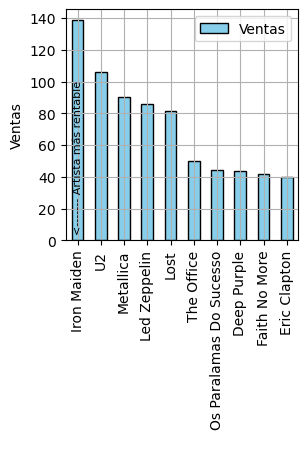

In [87]:
query = """
select ar.Name as Name_Artist, Sum(ii.UnitPrice) as Ventas from invoices i
inner join invoice_items ii on i.InvoiceId = ii.InvoiceId
inner join tracks t on ii.TrackId = t.TrackId
inner JOIN albums a on a.AlbumId = t.AlbumId 
inner join artists ar on a.ArtistId = ar.ArtistId 
group by Name_Artist order by Ventas DESC limit 10; 
"""

df = pd.read_sql_query(query, conn)

df.plot(
    kind="bar",        # tipo de gráfico
    x="Name_Artist",          # eje X
    y="Ventas",        # eje Y
    legend=True,      # sin leyenda
    color="skyblue",     # color opcional
    label = 'Ventas', 
    figsize=(3,3), 
    edgecolor="black", 
    xlabel = ' ')
plt.text(0, 5, '<------- Artista más rentable', ha="center", fontsize=8, rotation=90)
plt.ylabel("Ventas")
plt.grid()
plt.show()

### ¿Qué porcentaje de ventas representan los 3 artistas más vendidos respecto al total? 
Permite ver si unas pocas estrellas del catálogo generan la mayor parte de los ingresos, o si las ventas están más distribuidas entre muchos artistas. Esto indica dependencia del negocio en unos pocos artistas. Saber qué artistas concentran más ventas ayuda a decidir en quién invertir para futuras producciones, promociones o renovaciones de contratos.

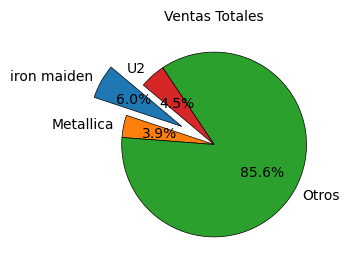

In [103]:
query = """
select ar.Name as Name_Artist, Round(Sum(ii.UnitPrice)*100/2328.6,1) as P_Ventas from invoices i
inner join invoice_items ii on i.InvoiceId = ii.InvoiceId
inner join tracks t on ii.TrackId = t.TrackId
inner JOIN albums a on a.AlbumId = t.AlbumId 
inner join artists ar on a.ArtistId = ar.ArtistId 
group by Name_Artist order by P_Ventas DESC limit 3; 
"""

df = pd.read_sql_query(query, conn)

P_Iron = df['P_Ventas'][0]
P_u2 = df['P_Ventas'][1]
P_Metallica = df['P_Ventas'][2]
P_Otros = 100-P_Metallica-P_u2-P_Iron
explode = (0.4, 0, 0, 0)

plt.figure(figsize=(3,3))
plt.pie([P_Iron, P_Metallica, P_Otros, P_u2],  labels=['iron maiden','Metallica', 'Otros', 'U2' ],  autopct='%1.1f%%',
        explode = explode,# agregar sombra
    startangle=140, 
       wedgeprops={'edgecolor': 'black', 'linewidth': 0.5} )
#plt.pie(df["Ingreso_Total"], labels=df["Artista"], autopct="%1.1f%%", startangle=140)
plt.title("Ventas Totales", fontsize = 10)
plt.savefig("Ventas_Totales.png")

plt.show()


### Ranking de clientes: ¿Quiénes son los 10 más valiosos (highest lifetime value)?
Estos clientes son estratégicos para programas de lealtad, ofertas especiales, comunicación personalizada y atención preferencial.

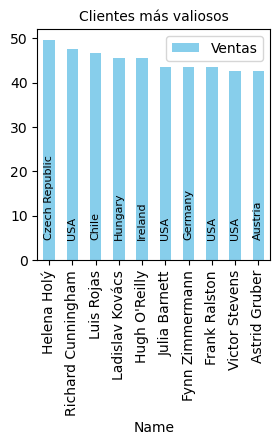

In [106]:
query = """
select Concat(c.FirstName, ' ', c.LastName) as Name, c.Country as Pais,  Round(Sum(i.Total),1) as LifetimeValue from invoices i 
inner join customers c on c.CustomerId = i.CustomerId
group by Name order by LifetimeValue  desc limit 10; 
"""

df = pd.read_sql_query(query, conn)
df.plot(
    kind="bar",        # tipo de gráfico
    x="Name",          # eje X
    y="LifetimeValue",        # eje Y
    legend=True,      # sin leyenda
    color="skyblue",     # color opcional
    label = 'Ventas', 
 figsize=(3,3))

for i, j in enumerate(df['Pais']):  
    plt.text(i, 5, j, ha="center", fontsize=8, rotation=90)

plt.title("Clientes más valiosos", fontsize = 10)
plt.savefig("Clientes_más_valiosos.png")

plt.show()

###  Qué generos musicales son los más rentables? 

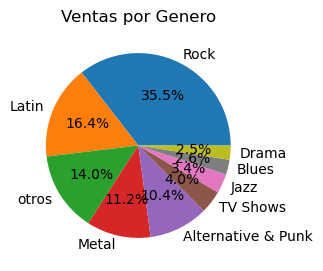

In [109]:
query = """
SELECT Genero, SUM(P_Ventas ) as Perc  from (select g.Name as Genre, Sum(ii.UnitPrice)*100/2328.6 as P_Ventas, 
	case 
		when Sum(ii.UnitPrice)*100/2328.6 > 2 then g.Name
		ELSE
			'otros'
		END as Genero
from invoices i
inner join invoice_items ii on i.InvoiceId = ii.InvoiceId
inner join tracks t on ii.TrackId = t.TrackId
inner JOIN albums a on a.AlbumId = t.AlbumId 
inner join artists ar on a.ArtistId = ar.ArtistId 
inner join genres g on g.GenreId = t.GenreId 
group by Genre 
order by P_Ventas DESC) group by GEnero order by Perc DESC ; 
"""

df = pd.read_sql_query(query, conn)

df.set_index("Genero")['Perc'].plot(
    figsize=(3,3),
    kind="pie",   
    legend=False, 
    autopct="%1.1f%%", 
    ylabel="")
plt.title("Ventas por Genero")
plt.savefig("Ventas_por_genero.png")
plt.show()


### Promedio de Gasto por Cliente vvs Porcentaje total de Ventas
El número de clientes por sí solo no garantiza más ventas, pero combinado con los datos de facturación, se puede ver qué mercados son más rentables. Abajo graficamos el gasto promedio por cliente y el porcentaje de ventas por cada Pais. En chile los clientes gastan más pero su porcentaje de ventas es menor que otros paises. 

Saber la distribución de clientes facilita comparaciones: por ejemplo, ¿un país con pocos clientes genera más ventas por cliente que otro con muchos? Esto lo observamos en la grafica "Comparación no_clientes y Ventas por País". 

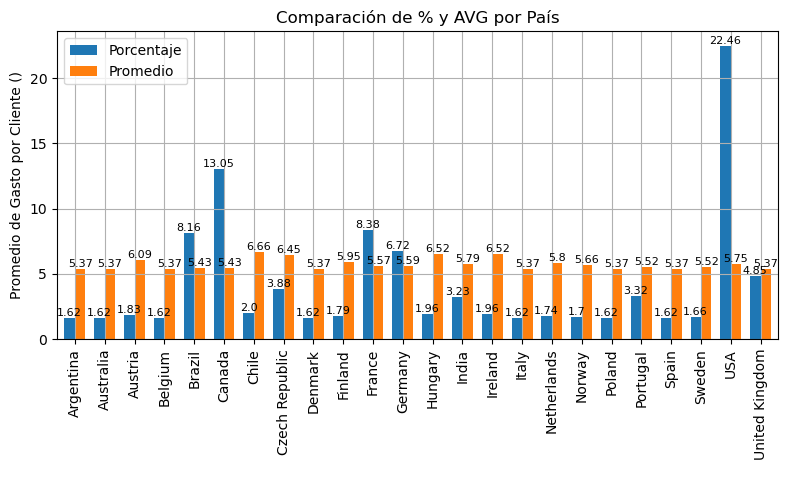

In [128]:
query = """
select i.BillingCountry as Country, sum(i.Total)*100/2328.6  as Porcentaje, avg(i.Total) as Promedio from invoices i
group  by Country; 

"""
df = pd.read_sql_query(query, conn)

df.set_index("Country", inplace=True)

# Gráfico de barras
ax = df.plot(kind="bar", figsize=(8,5), width=0.7, xlabel = " ")

for p in ax.patches:
    ax.annotate(
        f"{round(p.get_height(), 2)}",          # valor con 2 decimales
        (p.get_x() + p.get_width() / 2, p.get_height()),  # posición
        ha='center', va='bottom', fontsize=8, rotation=0
    )

plt.title("Comparación de % y AVG por País")
plt.ylabel("Promedio de Gasto por Cliente ()")
plt.xticks(rotation=90)  # rotamos etiquetas para mayor claridad
plt.legend()
plt.tight_layout()
plt.savefig("Ventas_por_pais.png")
plt.grid()
plt.show()

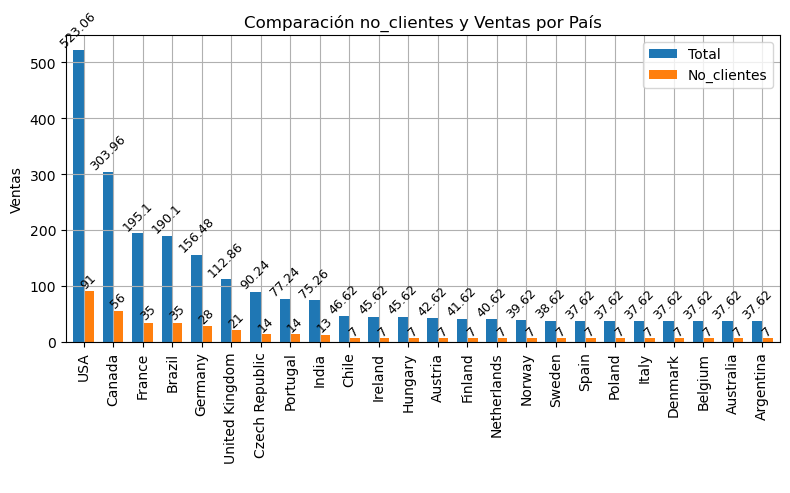

In [130]:
query = """
select i.BillingCountry as Country, sum(i.Total) as Total, COUNT(i.BillingCountry) as No_clientes from invoices i
group  by country order by Total DESC ; 
"""
df = pd.read_sql_query(query, conn)

df.set_index("Country", inplace=True)

# Gráfico de barras
ax = df.plot(kind="bar", figsize=(8,5), width=0.7, xlabel = " ")

for p in ax.patches: 
        ax.annotate(
            f"{round(p.get_height(), 2)}",          # valor con 2 decimales
            (p.get_x() + p.get_width() / 2, p.get_height()),  # posición
            ha='center', va='bottom', fontsize=9, rotation=45
        )

plt.title("Comparación no_clientes y Ventas por País")
plt.ylabel("Ventas")
plt.xticks(rotation=90)  # rotamos etiquetas para mayor claridad
plt.legend()
plt.tight_layout()
#plt.savefig("Clientes_por_pais.png")
plt.grid()
plt.show()

In [16]:
conn.close()